In [1]:
# initial imports for functions and otherwise
import pandas as pd
from prepare import prep_telco
from acquire import get_connection, get_telco_data
from modeling import dt_comp, rf_comp, knn_comp, lr_comp, model_comp
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy import stats
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Acquisition

In [2]:
# getting info from initial uncleaned telco dataset
telco = get_telco_data()
telco.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,DSL,Mailed check
1,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
2,1,2,1,0004-TLHLJ,Male,0,No,No,4,Yes,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Fiber optic,Electronic check
3,1,2,1,0011-IGKFF,Male,1,Yes,No,13,Yes,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Fiber optic,Electronic check
4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,Yes,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Fiber optic,Mailed check


# Preparation

In [3]:
# running prep function to do some of the cleaning for me and showing top 5 to see if prep worked
telco = prep_telco(telco)
telco.head()

,senior_citizen,tenure,monthly_charges,total_charges,churn,gender_,has_partner,has_dependents,has_phone_service,has_multiple_lines,contract,internet_service,has_automatic_payment,has_amenities,has_internet_service
0,0,9,65.6,593.30,No,0,1,1,1,1,1,1,0,0,1
1,0,9,59.9,542.40,No,1,0,0,1,2,0,1,0,0,1
2,0,4,73.9,280.85,Yes,1,0,0,1,1,0,2,0,0,1
3,1,13,98.0,1237.85,Yes,1,1,0,1,1,0,2,0,1,1
4,1,3,83.9,267.40,Yes,0,1,0,1,1,0,2,0,0,1


In [4]:
# checking data types for columns
telco.dtypes

senior_citizen             int64
tenure                     int64
monthly_charges          float64
total_charges            float64
churn                     object
gender_                    int64
has_partner                int64
has_dependents             int64
has_phone_service          int64
has_multiple_lines         int64
contract                   int64
internet_service           int64
has_automatic_payment      int64
has_amenities              int64
has_internet_service       int64
dtype: object

In [5]:
# Setting a new column for target
telco['target'] = (telco['churn'] == 'Yes')
telco = telco.drop(columns='churn')

In [6]:
# Split the cleaned date into train, validate, test 
train_validate, test = train_test_split(telco, test_size=0.2, random_state=117, stratify=telco['target'])
train, validate = train_test_split(train_validate, test_size=0.3, random_state=117, stratify=train_validate['target'])

In [7]:
train.head()

,senior_citizen,tenure,monthly_charges,total_charges,gender_,has_partner,has_dependents,has_phone_service,has_multiple_lines,contract,internet_service,has_automatic_payment,has_amenities,has_internet_service,target
4993,0,56,59.80,3457.45,1,1,1,1,1,2,1,1,0,1,False
190,0,5,96.10,453.40,1,0,0,1,1,0,2,0,0,1,True
5071,1,16,54.55,825.10,1,1,0,1,1,0,1,1,0,1,False
461,0,63,71.90,4479.20,1,0,0,1,2,2,1,1,1,1,False
2383,1,3,74.60,239.05,0,1,0,1,1,0,2,1,0,1,False


In [8]:
# verifiying the split percentages
print(f' {train.shape[0] / telco.shape[0]}, \
{validate.shape[0] / telco.shape[0]}, \
{test.shape[0] / telco.shape[0]} ')

 0.5598466562544371, 0.24009654976572484, 0.20005679397983814 


In [9]:
train.dtypes

senior_citizen             int64
tenure                     int64
monthly_charges          float64
total_charges            float64
gender_                    int64
has_partner                int64
has_dependents             int64
has_phone_service          int64
has_multiple_lines         int64
contract                   int64
internet_service           int64
has_automatic_payment      int64
has_amenities              int64
has_internet_service       int64
target                      bool
dtype: object

# Evaluation

In [10]:
# determining percentages from different categorical features
print(f"Churn rate:\n", round(train.target.mean(), 2))

print(f"\nFemale Churn rate:\n", round(train[train.gender_ == 0].target.mean(), 2))
print(f"Male Churn rate:\n", round(train[train.gender_ != 0].target.mean(), 2))

print(f"\nSenior Churn rate:\n", round(train[train.senior_citizen == 0].target.mean(), 2))
print(f"\nNot Senior Churn rate:\n", round(train[train.senior_citizen == 1].target.mean(), 2))

print(f"\nChurn rate of customers with higher than average monthly charge:\n", round(train[train.monthly_charges > (train.monthly_charges.mean())].target.mean(), 2))
print(f"Churn rate of customers with lower than average monthly charge:\n", round(train[train.monthly_charges < (train.monthly_charges.mean())].target.mean(), 2))

print(f"\nChurn rate of customers with most of the available amenities:\n", round(train[train.has_amenities == 1].target.mean(), 2))
print(f"Churn rate of customers without most of the available amenities:\n", round(train[train.has_amenities == 0].target.mean(), 2))

print(f"\nChurn rate of customers with dependents:\n", round(train[train.has_dependents == 1].target.mean(), 2))
print(f"Churn rate of customers without dependents:\n", round(train[train.has_dependents == 0].target.mean(), 2))

print(f"\nChurn rate of customers with partner:\n", round(train[train.has_partner == 1].target.mean(), 2))
print(f"Churn rate of customers without partner:\n", round(train[train.has_partner == 0].target.mean(), 2))

print(f"\nChurn rate of customers with 2 year contract:\n", round(train[train.contract == 2].target.mean(), 2))
print(f"Churn rate of customers with 1 year contract:\n", round(train[train.contract == 1].target.mean(), 2))
print(f"Churn rate of customers with monthly contract:\n", round(train[train.contract == 0].target.mean(), 2))

print(f"\nChurn rate of customers with higher than average tenure:\n", round(train[train.tenure > (train.tenure.mean())].target.mean(), 2))
print(f"Churn rate of customers with lower than average tenure:\n", round(train[train.tenure < (train.tenure.mean())].target.mean(), 2))

print(f"\nChurn rate of customers with total charges higher than average:\n", round(train[train.total_charges > (train.total_charges.mean())].target.mean(), 2))
print(f"Churn rate of customers without total chargeslower than average:\n", round(train[train.total_charges < (train.total_charges.mean())].target.mean(), 2))

print(f"\nChurn rate of customers with phone service:\n", round(train[train.has_phone_service == 1].target.mean(), 2))
print(f"Churn rate of customers without phone service:\n", round(train[train.has_phone_service == 0].target.mean(), 2))

print(f"\nChurn rate of customers with multiple lines:\n", round(train[train.has_multiple_lines == 1].target.mean(), 2))
print(f"Churn rate of customers without multiple lines:\n", round(train[train.has_multiple_lines == 0].target.mean(), 2))

print(f"\nChurn rate of customers with internet service:\n", round(train[train.has_internet_service  == 1].target.mean(), 2))
print(f"Churn rate of customers without internet service:\n", round(train[train.has_internet_service  == 0].target.mean(), 2))

print(f"\nChurn rate of customers with automatic payment:\n", round(train[train.has_automatic_payment == 1].target.mean(), 2))
print(f"Churn rate of customers without automatic payment:\n", round(train[train.has_automatic_payment == 0].target.mean(), 2))

Churn rate:
 0.27

Female Churn rate:
 0.26
Male Churn rate:
 0.27

Senior Churn rate:
 0.23

Not Senior Churn rate:
 0.42

Churn rate of customers with higher than average monthly charge:
 0.35
Churn rate of customers with lower than average monthly charge:
 0.16

Churn rate of customers with most of the available amenities:
 0.17
Churn rate of customers without most of the available amenities:
 0.29

Churn rate of customers with dependents:
 0.15
Churn rate of customers without dependents:
 0.31

Churn rate of customers with partner:
 0.2
Churn rate of customers without partner:
 0.32

Churn rate of customers with 2 year contract:
 0.02
Churn rate of customers with 1 year contract:
 0.12
Churn rate of customers with monthly contract:
 0.42

Churn rate of customers with higher than average tenure:
 0.12
Churn rate of customers with lower than average tenure:
 0.39

Churn rate of customers with total charges higher than average:
 0.18
Churn rate of customers without total chargeslower 

### The largest takeaways from the comparison of churn rate follow:
- The greatest difference in churn rate is contract type, the churn rate drops 40% from a monthly contract to a 2 year one.
- Having internet service reduced churn rate by 23%
- Having a lower than average monthly charge reduces churn rate by 19%
- Not being a senior citizen also shows a reduction of churn rate by 19%

In [11]:
print(f"\nChurn rate of customers with 2 year contract:\n", round(train[train.contract == 2].target.mean(), 2))
print(f"Churn rate of customers with 1 year contract:\n", round(train[train.contract == 1].target.mean(), 2))
print(f"Churn rate of customers with monthly contract:\n", round(train[train.contract == 0].target.mean(), 2))

print(f"\nSenior Churn rate:\n", round(train[train.senior_citizen == 0].target.mean(), 2))
print(f"Not Senior Churn rate:\n", round(train[train.senior_citizen == 1].target.mean(), 2))

print(f"\nChurn rate of customers with internet service:\n", round(train[train.has_internet_service  == 1].target.mean(), 2))
print(f"Churn rate of customers without internet service:\n", round(train[train.has_internet_service  == 0].target.mean(), 2))

print(f"\nChurn rate of customers with higher than average monthly charge:\n", round(train[train.monthly_charges > (train.monthly_charges.mean())].target.mean(), 2))
print(f"Churn rate of customers with lower than average monthly charge:\n", round(train[train.monthly_charges < (train.monthly_charges.mean())].target.mean(), 2))


Churn rate of customers with 2 year contract:
 0.02
Churn rate of customers with 1 year contract:
 0.12
Churn rate of customers with monthly contract:
 0.42

Senior Churn rate:
 0.23
Not Senior Churn rate:
 0.42

Churn rate of customers with internet service:
 0.3
Churn rate of customers without internet service:
 0.07

Churn rate of customers with higher than average monthly charge:
 0.35
Churn rate of customers with lower than average monthly charge:
 0.16


## Stats testing the largest drivers

In [12]:
# establishing alpha for all stats tests
α = 0.05

In [13]:
H0 = "churn rate is independent of monthly charges"
Hα = "churn rate is dependent of monthly charges"

observed = pd.crosstab(train['target'], train['monthly_charges'])
chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < α:
    print("We reject the null hypothesis that", H0)
    print("Evidence suggests that", Hα)
else:
    print("We fail to reject the null hypothesis")
    print("We find insufficient evidence to support the claim that", Hα)

We reject the null hypothesis that churn rate is independent of monthly charges
Evidence suggests that churn rate is dependent of monthly charges


In [14]:
H0 = "churn rate is independent of if a customer has amenities"
Hα = "churn rate is dependent on if a customer has amenities"

observed = pd.crosstab(train['target'], train['has_amenities'])
chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < α:
    print("We reject the null hypothesis that", H0)
    print("Evidence suggests that", Hα)
else:
    print("We fail to reject the null hypothesis")
    print("We find insufficient evidence to support the claim that", Hα)

We reject the null hypothesis that churn rate is independent of if a customer has amenities
Evidence suggests that churn rate is dependent on if a customer has amenities


In [15]:
H0 = "churn rate is independent of if a customer has internet service"
Hα = "churn rate is dependent on if a customer has internet service"

observed = pd.crosstab(train['target'], train['has_internet_service'])
chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < α:
    print("We reject the null hypothesis that", H0)
    print("Evidence suggests that", Hα)
else:
    print("We fail to reject the null hypothesis")
    print("We find insufficient evidence to support the claim that", Hα)

We reject the null hypothesis that churn rate is independent of if a customer has internet service
Evidence suggests that churn rate is dependent on if a customer has internet service


In [17]:
H0 = "churn rate is independent of their contract"
Hα = "churn rate is dependent on their contract"

observed = pd.crosstab(train['target'], train['contract'])
chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < α:
    print("We reject the null hypothesis that", H0)
    print("Evidence suggests that", Hα)
else:
    print("We fail to reject the null hypothesis")
    print("We find insufficient evidence to support the claim that", Hα)

We reject the null hypothesis that churn rate is independent of their contract
Evidence suggests that churn rate is dependent on their contract


## The main takeaway are that a lot of features have a statistical significance in affecting churn rate.

# Modeling

In [18]:
train.head()

,senior_citizen,tenure,monthly_charges,total_charges,gender_,has_partner,has_dependents,has_phone_service,has_multiple_lines,contract,internet_service,has_automatic_payment,has_amenities,has_internet_service,target
4993,0,56,59.80,3457.45,1,1,1,1,1,2,1,1,0,1,False
190,0,5,96.10,453.40,1,0,0,1,1,0,2,0,0,1,True
5071,1,16,54.55,825.10,1,1,0,1,1,0,1,1,0,1,False
461,0,63,71.90,4479.20,1,0,0,1,2,2,1,1,1,1,False
2383,1,3,74.60,239.05,0,1,0,1,1,0,2,1,0,1,False


In [19]:
# Establsihing train, validate, and test sets to begin checking models
X_train1 = train.drop(columns=['target'])
y_train1 = train['target']

X_validate1 = validate.drop(columns=['target'])
y_validate1 = validate['target']

X_test1 = test.drop(columns=['target'])
y_test1 = test['target']

## Baseline Accuracy

In [20]:
telco['baseline'] = telco['target'].value_counts().idxmax()
baseline_accuracy = (telco.baseline == telco.target).mean()
baseline_accuracy

0.7346301292063041

## Decision Tree

In [21]:
DecisionTreeClassifier?

Init signature:
DecisionTreeClassifier(
    *,
    criterion='gini',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    class_weight=None,
    ccp_alpha=0.0,
)
Docstring:     
A decision tree classifier.

Read more in the :ref:`User Guide <tree>`.

Parameters
----------
criterion : {"gini", "entropy", "log_loss"}, default="gini"
    The function to measure the quality of a split. Supported criteria are
    "gini" for the Gini impurity and "log_loss" and "entropy" both for the
    Shannon information gain, see :ref:`tree_mathematical_formulation`.

splitter : {"best", "random"}, default="best"
    The strategy used to choose the split at each node. Supported
    strategies are "best" to choose the best split and "random" to choose
    the best random split.

max_depth : int, default=None
    The maximum depth o

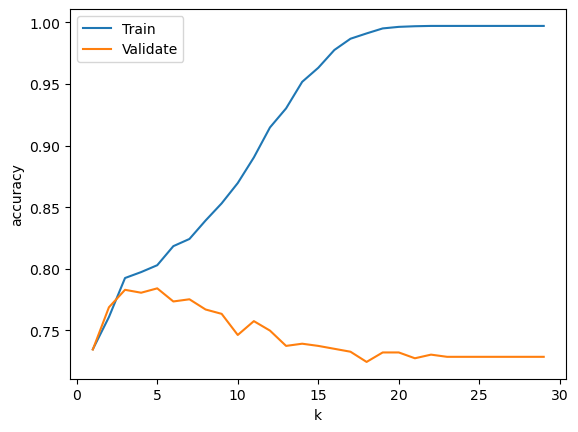

In [22]:
dt_comp()

# finding the best criteria
k_range = range(1,30)
train_score = []
validate_score = []
for k in k_range:
    clf = DecisionTreeClassifier(max_depth=k, random_state=117)
    clf.fit(X_train1, y_train1)
    train_score.append(clf.score(X_train1, y_train1))
    validate_score.append(clf.score(X_validate1, y_validate1))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.plot(k_range, train_score, label = 'Train')
plt.plot(k_range, validate_score, label = 'Validate')
plt.legend()
plt.show()

### It looks like a max depth of 5 is best for this Decision Tree

In [23]:
clf1 = DecisionTreeClassifier(max_depth=5)

clf1.fit(X_train1, y_train1)

dt_tr_acc = clf1.score(X_train1, y_train1)


clf1.fit(X_validate1, y_validate1)

dt_val_acc = clf1.score(X_validate1, y_validate1)

In [24]:
print(f'Ideal Decision Tree Accuracy Scores:\n\n\
Training Accuracy:\n{dt_tr_acc:2%}\n\n\
Validation Accuracy:\n{dt_val_acc:2%}\n\n\
Baseline Accuracy:\n{baseline_accuracy:2%}')

Ideal Decision Tree Accuracy Scores:

Training Accuracy:
80.294192%

Validation Accuracy:
80.898876%

Baseline Accuracy:
73.463013%


## Random Forest

In [25]:
RandomForestClassifier?

Init signature:
RandomForestClassifier(
    n_estimators=100,
    *,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None,
)
Docstring:     
A random forest classifier.

A random forest is a meta estimator that fits a number of decision tree
classifiers on various sub-samples of the dataset and uses averaging to
improve the predictive accuracy and control over-fitting.
The sub-sample size is controlled with the `max_samples` parameter if
`bootstrap=True` (default), otherwise the whole dataset is used to build
each tree.

Read more in the :ref:`User Guide <forest>`.

Parameters
----------
n_estimators : int, default=100
    The number of trees in the forest.


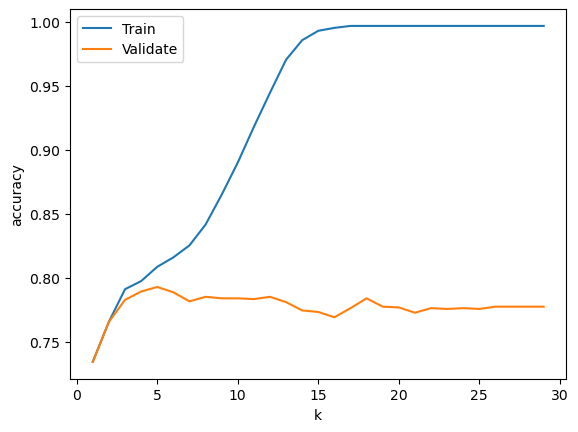

In [26]:
rf_comp()

### The ideal accuracy for Random Forest also appears to have a max depth of 5.

In [27]:
rf1 = RandomForestClassifier(max_depth=5)

rf1.fit(X_train1, y_train1)

rf_tr_acc = rf1.score(X_train1, y_train1)


rf1.fit(X_validate1, y_validate1)

rf_val_acc = rf1.score(X_validate1, y_validate1)

In [28]:
print(f'Ideal Random Forest Accuracy Scores:\n\n\
Training Accuracy:\n{rf_tr_acc:2%}\n\n\
Validation Accuracy:\n{rf_val_acc:2%}\n\n\
Baseline Accuracy:\n{baseline_accuracy:2%}')

Ideal Random Forest Accuracy Scores:

Training Accuracy:
80.420999%

Validation Accuracy:
80.721467%

Baseline Accuracy:
73.463013%


## KNN

In [29]:
KNeighborsClassifier?

Init signature:
KNeighborsClassifier(
    n_neighbors=5,
    *,
    weights='uniform',
    algorithm='auto',
    leaf_size=30,
    p=2,
    metric='minkowski',
    metric_params=None,
    n_jobs=None,
)
Docstring:     
Classifier implementing the k-nearest neighbors vote.

Read more in the :ref:`User Guide <classification>`.

Parameters
----------
n_neighbors : int, default=5
    Number of neighbors to use by default for :meth:`kneighbors` queries.

weights : {'uniform', 'distance'}, callable or None, default='uniform'
    Weight function used in prediction.  Possible values:

    - 'uniform' : uniform weights.  All points in each neighborhood
      are weighted equally.
    - 'distance' : weight points by the inverse of their distance.
      in this case, closer neighbors of a query point will have a
      greater influence than neighbors which are further away.
    - [callable] : a user-defined function which accepts an
      array of distances, and returns an array of the same shape

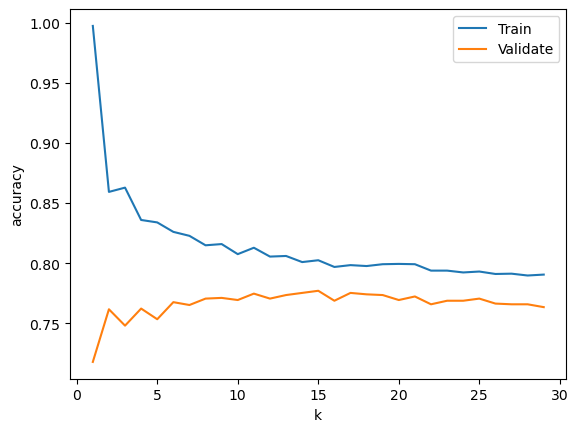

In [30]:
knn_comp()

### The ideal accuracy for K Nearest Neighbors appears to occur at 'n_neighbors=15'.

In [31]:
knn1 = KNeighborsClassifier(n_neighbors=15)

knn1.fit(X_train1, y_train1)

knn_tr_acc = knn1.score(X_train1,y_train1)


knn1.fit(X_validate1, y_validate1)

knn_val_acc = knn1.score(X_validate1, y_validate1)

In [32]:
print(f'Ideal Decision Tree Accuracy Scores:\n\n\
Training Accuracy:\n{knn_tr_acc:2%}\n\n\
Validation Accuracy:\n{knn_val_acc:2%}\n\n\
Baseline Accuracy:\n{baseline_accuracy:2%}')

Ideal Decision Tree Accuracy Scores:

Training Accuracy:
80.243469%

Validation Accuracy:
77.942046%

Baseline Accuracy:
73.463013%


## Logistic Regression

In [33]:
LogisticRegression?

Init signature:
LogisticRegression(
    penalty='l2',
    *,
    dual=False,
    tol=0.0001,
    C=1.0,
    fit_intercept=True,
    intercept_scaling=1,
    class_weight=None,
    random_state=None,
    solver='lbfgs',
    max_iter=100,
    multi_class='auto',
    verbose=0,
    warm_start=False,
    n_jobs=None,
    l1_ratio=None,
)
Docstring:     
Logistic Regression (aka logit, MaxEnt) classifier.

In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
scheme if the 'multi_class' option is set to 'ovr', and uses the
cross-entropy loss if the 'multi_class' option is set to 'multinomial'.
(Currently the 'multinomial' option is supported only by the 'lbfgs',
'sag', 'saga' and 'newton-cg' solvers.)

This class implements regularized logistic regression using the
'liblinear' library, 'newton-cg', 'sag', 'saga' and 'lbfgs' solvers. **Note
that regularization is applied by default**. It can handle both dense
and sparse input. Use C-ordered arrays or CSR matrices containi

### We won't be able to see the best identifiers through a visual here, so we'll do some trial and error to determine best criteria.

In [34]:
# Just to see the train table again
train.head()

,senior_citizen,tenure,monthly_charges,total_charges,gender_,has_partner,has_dependents,has_phone_service,has_multiple_lines,contract,internet_service,has_automatic_payment,has_amenities,has_internet_service,target
4993,0,56,59.80,3457.45,1,1,1,1,1,2,1,1,0,1,False
190,0,5,96.10,453.40,1,0,0,1,1,0,2,0,0,1,True
5071,1,16,54.55,825.10,1,1,0,1,1,0,1,1,0,1,False
461,0,63,71.90,4479.20,1,0,0,1,2,2,1,1,1,1,False
2383,1,3,74.60,239.05,0,1,0,1,1,0,2,1,0,1,False


In [35]:
lr_comp()

Logistic Regression Model Accuracy Scores:

Baseline Accuracy Score:
73.463013%

Model 1 Train Accuracy Score:
80.167385%
Model 1 Validate Accuracy Score:
79.302188%

Model 2 Train Accuracy Score:
79.939133%
Model 2 Validate Accuracy Score:
78.888232%

Model 3 Train Accuracy Score:
79.431905%
Model 3 Validate Accuracy Score:
78.356002%

Model 4 Train Accuracy Score:
78.899315%
Model 4 Validate Accuracy Score:
78.415139%

Model 5 Train Accuracy Score:
78.721785%
Model 5 Validate Accuracy Score:
76.700177%    


### Model 1 appeared to do the best in accuracy with a nominal falloff for it's validation score.

## Culmination of Model Accuracy Scores

In [36]:
model_comp()

Model Train and Validate Accuracy Scores: 

Baseline Accuracy: 
73.463013%

Decision Tree Train Score: 
80.294192%
Decision Tree Validate Score: 
80.898876%

Random Forest Train Score: 
80.142024%
Random Forest Validate Score: 
81.194559%

K Nearest Neighbor Train Score: 
80.243469%
K Nearest Neighbor Validate Score: 
77.942046%

Logistic Regression Train Score: 
80.167385%
Logistic Regression Validate Score: 
79.302188%




### The Random Forest and the Decision Tree are extremely close so let's run the test set on both

## Now to run the test set to see how the final model performs.

In [37]:
clf1.fit(X_test1, y_test1)

dt_test_acc = clf1.score(X_test1, y_test1)


print(f'Ideal Decision Tree Accuracy Scores:\n\n\
Training Accuracy:\n{dt_tr_acc:2%}\n\n\
Validation Accuracy:\n{dt_val_acc:2%}\n\n\
Test Accuracy:\n{dt_test_acc:2%}\n\n\
Baseline Accuracy:\n{baseline_accuracy:2%}')

Ideal Decision Tree Accuracy Scores:

Training Accuracy:
80.294192%

Validation Accuracy:
80.898876%

Test Accuracy:
81.689141%

Baseline Accuracy:
73.463013%


In [38]:
rf1.fit(X_test1, y_test1)

rf_test_acc = rf1.score(X_test1, y_test1)


print(f'Ideal Random Forest Accuracy Scores:\n\n\
Training Accuracy:\n{rf_tr_acc:2%}\n\n\
Validation Accuracy:\n{rf_val_acc:2%}\n\n\
Test Accuracy:\n{rf_test_acc:2%}\n\n\
Baseline Accuracy:\n{baseline_accuracy:2%}')

Ideal Random Forest Accuracy Scores:

Training Accuracy:
80.420999%

Validation Accuracy:
80.721467%

Test Accuracy:
81.618169%

Baseline Accuracy:
73.463013%


### Although both models outdid the baseline, the Random Forest Model did slightly better so that's the model we're going with.